### Dependency

In [1]:
## utils
import torch

## data and visualization
import torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

## model
import torch.nn as nn

## training
import torch.optim as optim
import torch.nn.functional as F
import tqdm

In [2]:
# reproducilibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda:0


## 1. Data Preparation

In [5]:
## mount the drive and unzip the dataset dir
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !unzip drive/My\ Drive/dataset.zip

In [7]:
root = "./dataset/"

In [8]:
# transforms (data augmentation)
data_transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [9]:
# create the dataset
dataset = torchvision.datasets.ImageFolder(
    root=root,
    transform=data_transforms
)

In [10]:
# split the data into train and val set
val_size = int(0.05*len(dataset))
train_size = len(dataset) - val_size
train, val = random_split(dataset=dataset, lengths=[train_size, val_size])

In [11]:
print(f'dataset.size {len(dataset)}\ntrain.size {len(train)}\nval.size {len(val)}')

dataset.size 27558
train.size 26181
val.size 1377


In [12]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
val_loader = DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)

##### Sample Visualization
- It can be also visualzied using torchvision make_grid

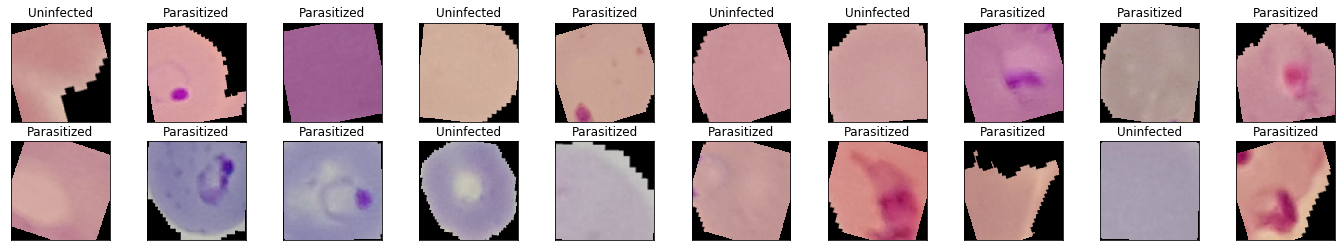

In [ ]:
# do not run this cell unless it is neccessary
classes = dataset.classes
images, labels = next(iter(train_loader))
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(24, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
plt.show()

## 2. Model

In [13]:
# ## install pytorch-lightning and efficientnet models
# !pip install pytorch_lightning efficientnet_pytorch

In [14]:
# from efficientnet_pytorch import EfficientNet
from torch.utils import tensorboard

In [15]:
class Model(nn.Module):
    
    def __init__(self, num_classes=2):
        super(Model, self).__init__()

        # fine tuning pretrained model
        self.base = torchvision.models.resnet101(pretrained=True)
        self.classifier = nn.Linear(in_features=1000, out_features=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        features = self.base(x)
        outputs = self.classifier(features)
        return self.sigmoid(outputs)

## 3. Training 

In [16]:
from pytorch_lightning.metrics import classification

In [17]:
model = Model().to(device)

In [18]:
# optimizer, loss, and logger
writer = tensorboard.SummaryWriter()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)
criterion = nn.MSELoss().to(device)

In [19]:
def metrics(y, y_):
    acc = classification.accuracy(y, y_, num_classes=2).item()
    precision = classification.precision(y, y_).item()
    recall = classification.recall(y, y_).item()
    f1 = classification.f1_score(y, y_).item()
    return acc, precision, recall, f1

In [20]:
def eval(model, data, criterion):
    loss = []
    acc = []
    precision = []
    recall = []
    f1 = []

    with torch.no_grad():
        for x, y in data:

            x, y = x.to(device), y.to(device)

            outputs = model(x)
            l = criterion(outputs.view(-1), y.type_as(outputs))
            loss.append(l.item())

            a, p, r, f = metrics(outputs.view(-1)>0.5, y)

            acc.append(a)
            precision.append(p)
            recall.append(r)
            f1.append(f)

    return sum(loss)/len(loss), sum(acc)/len(acc), sum(precision)/len(precision), sum(recall)/len(recall), sum(f1)/len(f1)


In [21]:
EPOCHS = 2
TOTAL_STEPS = len(train_loader)*EPOCHS
STEPS = 0
EPOCH_PROGRESS = tqdm.tqdm(total=EPOCHS, desc="EPOCHS", position=0)

for epoch in range(EPOCHS):
    loss = []
    acc = []
    precision = []
    recall = []
    f1 = []

    STEP_PROGRESS = tqdm.tqdm(total=len(train_loader), desc="Steps", position=0)
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        outputs = model(x).view(-1)

        l = criterion(outputs, y.type_as(outputs))

        # backpropagate the loss
        optimizer.zero_grad()
        l.backward()
        optimizer.step()


        loss.append(l.item())
        a, p, r, f = metrics(outputs>0.5, y)
        acc.append(a)
        precision.append(p)
        recall.append(r)
        f1.append(f)

        # steps wise metrics writing
        writer.add_scalar("Step_loss", l.item(), STEPS)
        writer.add_scalar("Step_acc", a, STEPS)
        writer.add_scalar("Step_precision", p, STEPS)
        writer.add_scalar("Step_recall", f, STEPS)
        writer.add_scalar("Step_f1", f, STEPS)

        if STEPS%400==0:
            print(f'Steps {STEPS}/{TOTAL_STEPS} | Train_loss {l.item():.4f} | Train_acc {a:.4f}')

        STEPS += 1
        STEP_PROGRESS.update(1)


    avg_loss, avg_acc, avg_precision, avg_recall, avg_f1 = sum(loss)/len(loss), sum(acc)/len(acc), sum(precision)/len(precision), sum(recall)/len(recall), sum(f1)/len(f1)
    val_loss, val_acc, val_precision, val_recall, val_f1 = eval(model, val_loader, criterion)

    # write epoch wise training and validation to tensorboard logger
    writer.add_scalar("Train_loss", avg_loss, epoch)
    writer.add_scalar("Train_acc", avg_acc, epoch)
    writer.add_scalar("Train_precision", avg_precision, epoch)
    writer.add_scalar("Train_recall", avg_recall, epoch)
    writer.add_scalar("Train_f1", avg_f1, epoch)

    writer.add_scalar("Val_loss", val_loss, epoch)
    writer.add_scalar("Val_acc", val_acc, epoch)
    writer.add_scalar("Val_precision", val_precision, epoch)
    writer.add_scalar("Val_recall", val_recall, epoch)
    writer.add_scalar("Val_f1", val_f1, epoch)

    print(f'Epoch {epoch}/{EPOCHS} | Steps {STEPS}/{TOTAL_STEPS} | Train_loss {avg_loss:.4f} | Train_acc {avg_acc:.4f} | Val_loss {val_loss:.4f} | Val_acc {val_acc:.4f}')
    EPOCH_PROGRESS.update(1)

Steps:   0%|          | 1/819 [00:01<15:49,  1.16s/it]

Steps 0/1638 | Train_loss 0.2863917648792267 | Train_acc 0.375


Steps:  49%|████▉     | 401/819 [04:36<05:02,  1.38it/s]

Steps 400/1638 | Train_loss 0.12317877262830734 | Train_acc 0.78125


Steps:  98%|█████████▊| 801/819 [09:24<00:12,  1.39it/s]

Steps 800/1638 | Train_loss 0.06643473356962204 | Train_acc 0.9375


Steps: 100%|██████████| 819/819 [09:37<00:00,  1.24it/s]/home/macab/miniconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: You have set 2 number of classes if different from predicted (1) and target (1) number of classes
  warnings.warn(*args, **kwargs)
Steps:   0%|          | 0/819 [00:00<?, ?it/s].76s/it]

Epoch 0/2 | Steps 819/1638 | Train_loss 0.1042 | Train_acc 0.8563 | Val_loss 0.0935 | Val_acc 0.8665


Steps:  47%|████▋     | 382/819 [04:35<05:14,  1.39it/s]

Steps 1200/1638 | Train_loss 0.0466507188975811 | Train_acc 0.90625


Steps:  95%|█████████▌| 782/819 [09:25<00:26,  1.39it/s]

Steps 1600/1638 | Train_loss 0.11386960744857788 | Train_acc 0.84375


EPOCHS: 100%|██████████| 2/2 [19:49<00:00, 591.85s/it]s]

Epoch 1/2 | Steps 1638/1638 | Train_loss 0.0924 | Train_acc 0.8719 | Val_loss 0.0830 | Val_acc 0.8906


In [23]:
# see the tensorboard logs
!tensorboard --logdir=runs/

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## 4. Evaluate

In [40]:
torch.save(model, "model.pth")

In [29]:
trained = torch.load("model.pth")

In [38]:
_, acc, precision, recall, f1_score = eval(trained, val_loader, criterion)
print(f'Validation Report\nNo of Samples = {len(val_loader)*BATCH_SIZE}\nAccuracy = {acc:.4f} | Precision = {precision:.4f} | Recall = {precision:.4f} | F1_score = {f1_score:.4f}')

Validation Report
No of Samples = 1408
Accuracy = 0.8764 | Precision = 0.8787 | Recall = 0.8787 | F1_score = 0.8740


## To do
- Train SOTA models
- Model Checkpoints
- Optimization